# **Explainable AI for Heart Disease Prediction: A SHAP and LIME Analysis**

## **Project Overview**
This project builds machine learning models (Random Forest and XGBoost) to predict heart disease presence from clinical features in 303 patient records. The focus is on model interpretability using SHAP (global and local feature importance) and LIME (local explanations) to understand which clinical factors drive predictions. The analysis aims to demonstrate how explainability techniques can build trust in healthcare AI by revealing what the model learned and why it makes specific predictions for individual patients.

## **Setup and Data Loading**

In [1]:
# Install required packages
!pip install shap lime xgboost -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
import shap
from lime import lime_tabular
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# Load the dataset from Google Drive
df = pd.read_csv('/content/drive/MyDrive/Projects/Explainable AI for Heart Disease Prediction Project/Data/heart_disease_uci.csv')

df.head()


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


## **Data Exploration**

In [14]:
# Basic information
df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


In [16]:
# Check for missing values
df.isnull().sum()

,0
id,0
age,0
sex,0
dataset,0
cp,0
trestbps,59
chol,30
fbs,90
restecg,2
thalch,55


In [24]:
# Check target variable distribution
print(df['num'].value_counts())
print("\nPercentage distribution:")
print(df['num'].value_counts(normalize=True) * 100)

num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

Percentage distribution:
num
0    44.673913
1    28.804348
2    11.847826
3    11.630435
4     3.043478
Name: proportion, dtype: float64


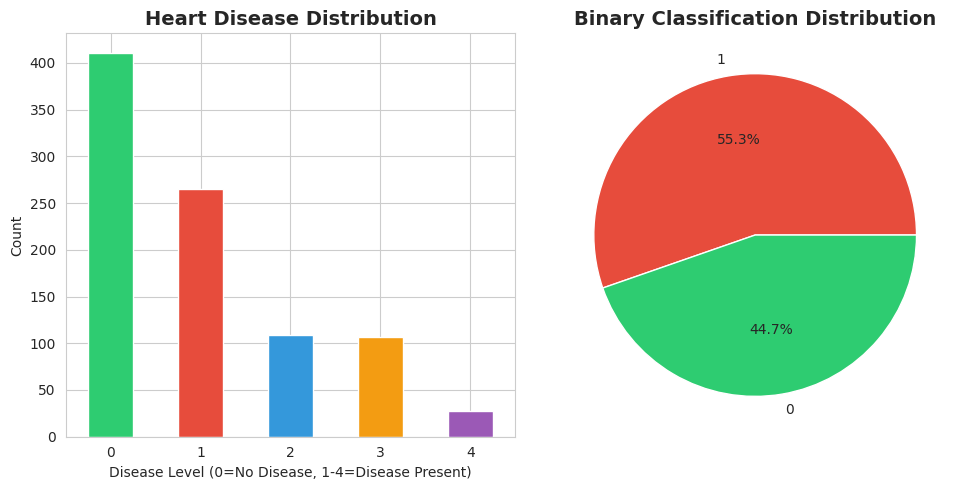

In [28]:
# Visualize target distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df['num'].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c', '#3498db', '#f39c12', '#9b59b6'])
plt.title('Heart Disease Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Disease Level (0=No Disease, 1-4=Disease Present)')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Activate the second subplot
plt.subplot(1, 2, 2)
# Binary classification: 0 = No disease, 1 = Disease present
binary_target = (df['num'] > 0).astype(int)
binary_target.value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#e74c3c', '#2ecc71'])
plt.title('Binary Classification Distribution', fontsize=14, fontweight='bold')
plt.ylabel('')  # Remove the y-label for pie charts

plt.tight_layout()
plt.show()

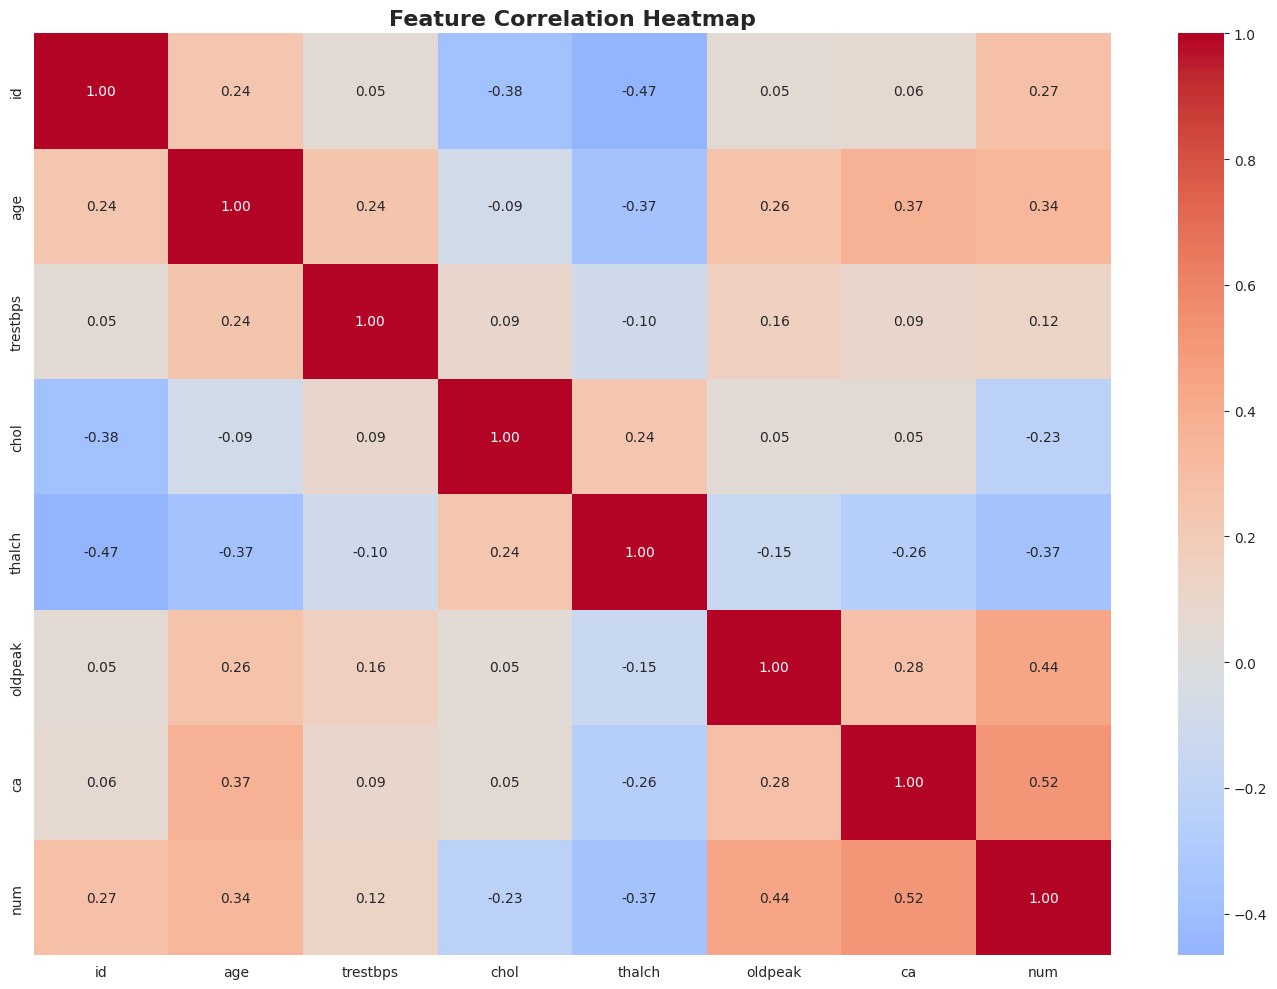

In [31]:
 # Feature correlation heatmap
plt.figure(figsize=(14, 10))
# Select only numeric columns for correlation calculation
correlation_matrix = df.select_dtypes(include=np.number).corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## **Data Preprocessing**

In [32]:
# Convert target to binary (0 = no disease, 1 = disease present)
df['target'] = (df['num'] > 0).astype(int)

# Separate features and target
X = df.drop(['num', 'target'], axis=1)
y = df['target']

# Store feature names for later use
feature_names = X.columns.tolist()

print(f"\n✅ Features: {feature_names}")
print(f"✅ Target: Binary classification (0=No Disease, 1=Disease)")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Training set size: {X_train.shape[0]} samples")
print(f"📊 Test set size: {X_test.shape[0]} samples")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"\nClass distribution in test set:")
print(y_test.value_counts())


✅ Features: ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
✅ Target: Binary classification (0=No Disease, 1=Disease)

📊 Training set size: 736 samples
📊 Test set size: 184 samples

Class distribution in training set:
target
1    407
0    329
Name: count, dtype: int64

Class distribution in test set:
target
1    102
0     82
Name: count, dtype: int64


In [37]:
# Feature scaling
from sklearn.impute import SimpleImputer
# Create copies of X_train and X_test to avoid modifying the original DataFrames directly
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

# Drop 'id' column as it's an identifier and not a predictive feature
if 'id' in X_train_processed.columns:
    X_train_processed = X_train_processed.drop('id', axis=1)
    X_test_processed = X_test_processed.drop('id', axis=1)

# Convert 'fbs' and 'exang' from object type (True/False) to numerical (1/0)
# Map True to 1, False to 0. NaN values will remain NaN and be handled by the numerical imputer.
X_train_processed['fbs'] = X_train_processed['fbs'].map({True: 1, False: 0})
X_test_processed['fbs'] = X_test_processed['fbs'].map({True: 1, False: 0})
X_train_processed['exang'] = X_train_processed['exang'].map({True: 1, False: 0})
X_test_processed['exang'] = X_test_processed['exang'].map({True: 1, False: 0})

# Identify numerical and categorical columns after boolean conversions
numerical_cols = X_train_processed.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train_processed.select_dtypes(include='object').columns.tolist()

# Impute missing values for numerical features using the mean strategy
imputer_numerical = SimpleImputer(strategy='mean')
X_train_processed[numerical_cols] = imputer_numerical.fit_transform(X_train_processed[numerical_cols])
X_test_processed[numerical_cols] = imputer_numerical.transform(X_test_processed[numerical_cols])

# One-hot encode categorical features
# `drop_first=True` avoids multicollinearity by dropping the first category column.
# `dtype=int` ensures the dummy variables are integers.
X_train_processed = pd.get_dummies(X_train_processed, columns=categorical_cols, drop_first=True, dtype=int)
X_test_processed = pd.get_dummies(X_test_processed, columns=categorical_cols, drop_first=True, dtype=int)

# Align columns between training and test sets after one-hot encoding
# This step ensures that both dataframes have the same columns in the same order,
# even if some categories are present in one set but not the other.
train_cols = X_train_processed.columns
test_cols = X_test_processed.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test_processed[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train_processed[c] = 0

X_test_processed = X_test_processed[train_cols] # Ensure same order and columns as train

# Apply StandardScaler to the entirely numerical and imputed DataFrame
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)


In [40]:
# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_processed.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train_processed.columns, index=X_test.index)

print("\n✅ Data preprocessing completed!")


✅ Data preprocessing completed!


## **Model Training**

In [42]:
# Train Random Forest
print("\n🌲 Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
print("✅ Random Forest trained!")

# Train XGBoost
print("\n🚀 Training XGBoost Classifier...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train_scaled, y_train)
print("✅ XGBoost trained!")



🌲 Training Random Forest Classifier...
✅ Random Forest trained!

🚀 Training XGBoost Classifier...
✅ XGBoost trained!


## **Model Evaluation**

In [49]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
   """Comprehensive model evaluation"""

   # Predictions
   y_train_pred = model.predict(X_train)
   y_test_pred = model.predict(X_test)
   y_test_proba = model.predict_proba(X_test)[:, 1]

   # Metrics
   train_acc = accuracy_score(y_train, y_train_pred)
   test_acc = accuracy_score(y_test, y_test_pred)
   precision = precision_score(y_test, y_test_pred)
   recall = recall_score(y_test, y_test_pred)
   auc = roc_auc_score(y_test, y_test_proba)

   print(f"\n📊 {model_name} Results:")
   print(f"{'='*50}")
   print(f"Training Accuracy:   {train_acc:.4f}")
   print(f"Test Accuracy:       {test_acc:.4f}")
   print(f"Precision:           {precision:.4f}")
   print(f"Recall:              {recall:.4f}")
   print(f"AUC-ROC:             {auc:.4f}")

In [54]:
# Evaluate Random Forest model
evaluate_model(rf_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Random Forest')


📊 Random Forest Results:
Training Accuracy:   0.9715
Test Accuracy:       0.8424
Precision:           0.8349
Recall:              0.8922
AUC-ROC:             0.9255


In [55]:
# Evaluate XGBoost model
evaluate_model(xgb_model, X_train_scaled, X_test_scaled, y_train, y_test, 'XGBoost')


📊 XGBoost Results:
Training Accuracy:   0.9647
Test Accuracy:       0.8478
Precision:           0.8491
Recall:              0.8824
AUC-ROC:             0.9029


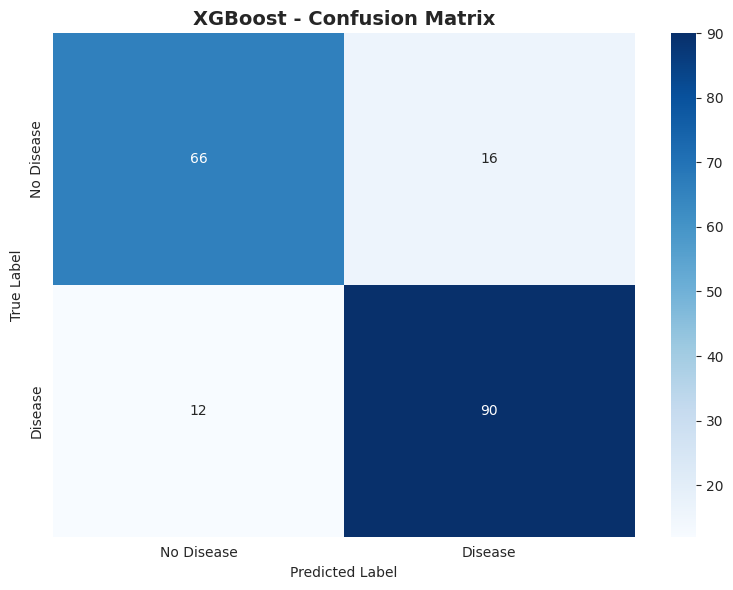

In [56]:
# Confusion Matrix
# The variables y_test_pred and model_name were defined locally within the evaluate_model function.
# To generate the confusion matrix, we need to re-obtain the predictions or ensure these variables are in scope.
# Assuming we want the confusion matrix for the last evaluated model (XGBoost)
y_test_pred = xgb_model.predict(X_test_scaled)
model_name = 'XGBoost' # Explicitly setting model name for the plot title

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [63]:
# Classification Report
print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_test_pred,
                                target_names=['No Disease', 'Disease']))



📋 Classification Report:
              precision    recall  f1-score   support

  No Disease       0.85      0.80      0.82        82
     Disease       0.85      0.88      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.85       184
weighted avg       0.85      0.85      0.85       184



In [65]:
# Compare models

# Get predictions and probabilities for Random Forest
rf_pred = rf_model.predict(X_test_scaled)
rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Get predictions and probabilities for XGBoost
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC-ROC'],
    'Random Forest': [
        accuracy_score(y_test, rf_pred),
        precision_score(y_test, rf_pred),
        recall_score(y_test, rf_pred),
        roc_auc_score(y_test, rf_proba)
    ],
    'XGBoost': [
        accuracy_score(y_test, xgb_pred),
        precision_score(y_test, xgb_pred),
        recall_score(y_test, xgb_pred),
        roc_auc_score(y_test, xgb_proba)
    ]
})

print(comparison_df.to_string(index=False))

   Metric  Random Forest  XGBoost
 Accuracy       0.842391 0.847826
Precision       0.834862 0.849057
   Recall       0.892157 0.882353
  AUC-ROC       0.925514 0.902917


### **Local SHAP Analysis (Individual Predictions)**


📊 Generating SHAP Waterfall Plots for Individual Cases...

📍 Case 1:
   True Label: 1 (Disease)
   Predicted: 1 (Disease)
   Prediction Probability: 0.5366


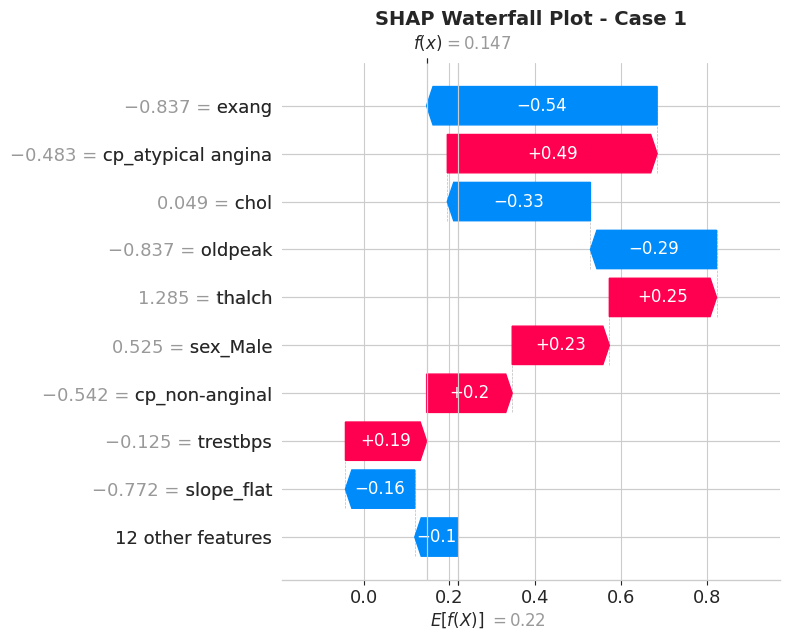


📍 Case 11:
   True Label: 1 (Disease)
   Predicted: 0 (No Disease)
   Prediction Probability: 0.4508


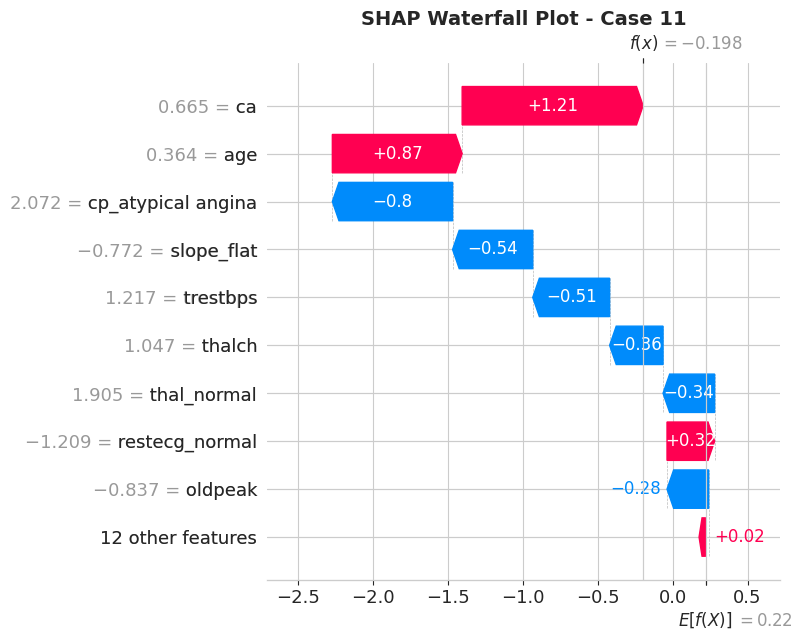


📍 Case 26:
   True Label: 1 (Disease)
   Predicted: 1 (Disease)
   Prediction Probability: 0.9874


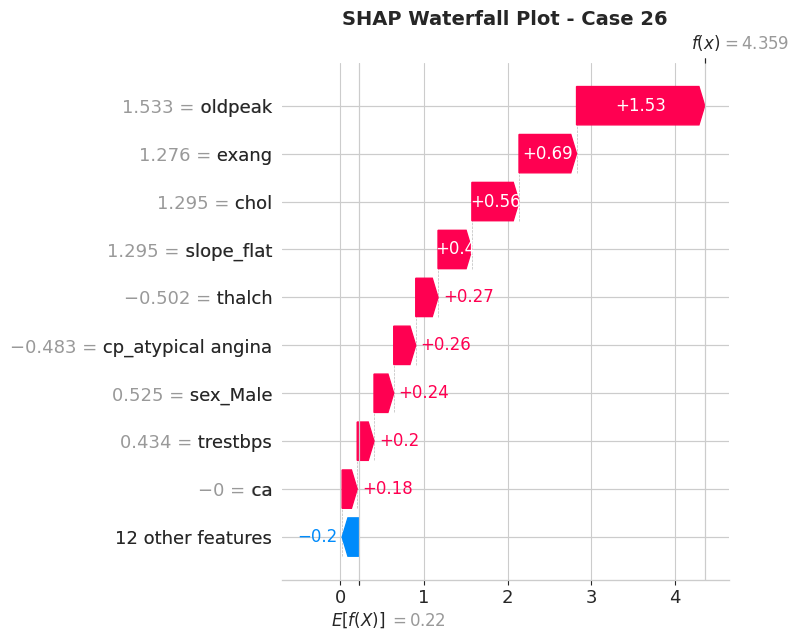

In [82]:
# SHAP Waterfall Plots for Individual Predictions
print("\n📊 Generating SHAP Waterfall Plots for Individual Cases...")

# Select interesting cases
case_indices = [0, 10, 25]  # Different test cases

for idx in case_indices:
    print(f"\n📍 Case {idx + 1}:")
    print(f"   True Label: {y_test.iloc[idx]} ({'Disease' if y_test.iloc[idx] == 1 else 'No Disease'})")
    print(f"   Predicted: {best_model.predict(X_test_scaled.iloc[[idx]])[0]} ({'Disease' if best_model.predict(X_test_scaled.iloc[[idx]])[0] == 1 else 'No Disease'})")
    print(f"   Prediction Probability: {best_model.predict_proba(X_test_scaled.iloc[[idx]])[0][1]:.4f}")

    plt.figure(figsize=(12, 6))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[idx],
            base_values=explainer.expected_value,
            data=X_test_scaled.iloc[idx],
            feature_names=X_test_scaled.columns.tolist() # Use the columns from the scaled data
        ),
        show=False
    )
    plt.title(f'SHAP Waterfall Plot - Case {idx + 1}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## **SHAP Analysis**


🌍 Generating Global SHAP Summary Plot for XGBoost...


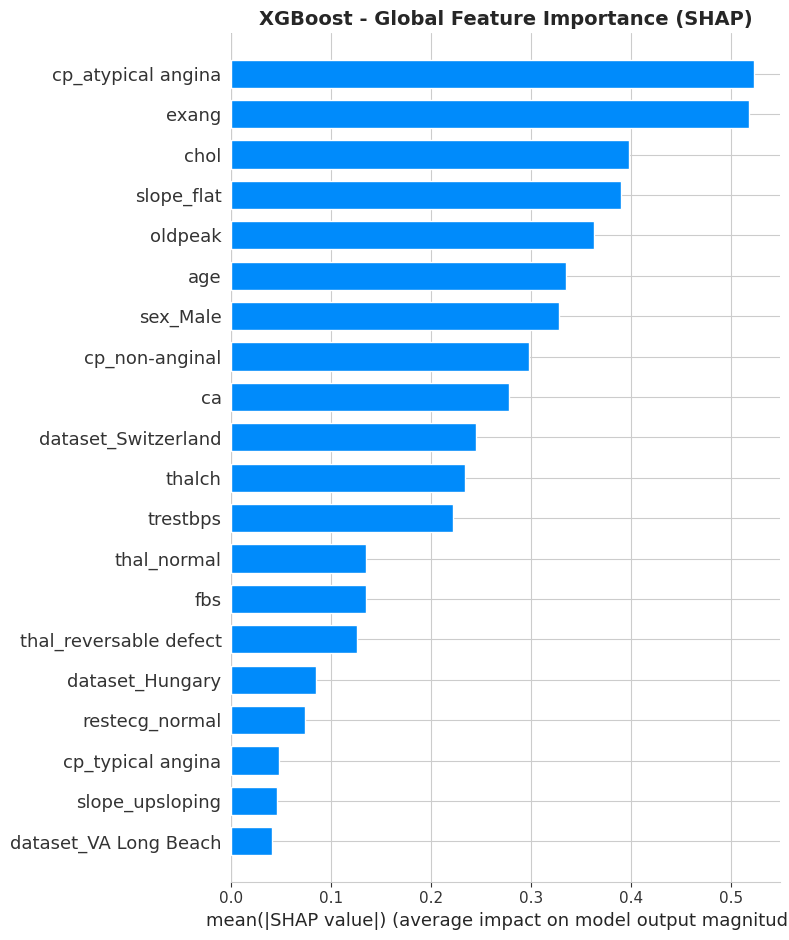

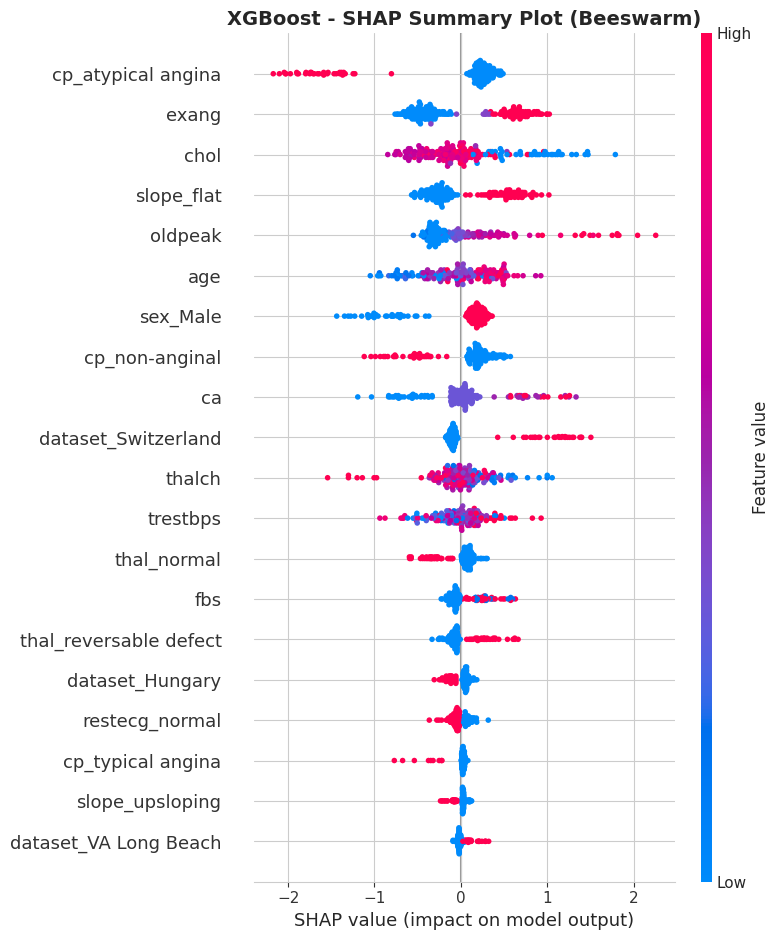

✅ Global SHAP analysis completed!


In [57]:
# Initialize JS for SHAP plots
shap.initjs()

# Explain global feature importance for XGBoost using SHAP
print("\n🌍 Generating Global SHAP Summary Plot for XGBoost...")
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test_scaled)

# SHAP Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_xgb, X_test_scaled, plot_type="bar", show=False)
plt.title('XGBoost - Global Feature Importance (SHAP)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# SHAP Summary Plot (beeswarm)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_xgb, X_test_scaled, show=False)
plt.title('XGBoost - SHAP Summary Plot (Beeswarm)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Global SHAP analysis completed!")

In [73]:
# Calculate mean absolute SHAP values for feature importance ranking
shap_importance = pd.DataFrame({
    'Feature': X_test_scaled.columns.tolist(),
    'Mean |SHAP|': np.abs(shap_values).mean(axis=0)
}).sort_values('Mean |SHAP|', ascending=False)

print("\n📊 Top Features by Mean Absolute SHAP Values:")
print(shap_importance.to_string(index=False))


📊 Top Features by Mean Absolute SHAP Values:
                 Feature  Mean |SHAP|
      cp_atypical angina     0.522803
                   exang     0.517603
                    chol     0.398186
              slope_flat     0.389889
                 oldpeak     0.363215
                     age     0.334439
                sex_Male     0.328354
          cp_non-anginal     0.298215
                      ca     0.277956
     dataset_Switzerland     0.245084
                  thalch     0.233822
                trestbps     0.221775
             thal_normal     0.134916
                     fbs     0.134412
  thal_reversable defect     0.125866
         dataset_Hungary     0.084710
          restecg_normal     0.073982
       cp_typical angina     0.047792
         slope_upsloping     0.046003
   dataset_VA Long Beach     0.041234
restecg_st-t abnormality     0.027471


## **LIME Analysis**

In [75]:
# Initialize LIME explainer
print("\n🔍 Initializing LIME TabularExplainer...")
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=X_train_scaled.columns.tolist(), # Use the column names from the scaled training data
    class_names=['No Disease', 'Disease'],
    mode='classification'
)

print("✅ LIME explainer initialized!")


🔍 Initializing LIME TabularExplainer...
✅ LIME explainer initialized!



📍 LIME Explanation - Case 1

True Label: 1 (Disease)
Predicted: 1 (Disease)
Prediction Probabilities: No Disease=0.4634, Disease=0.5366

📊 LIME Feature Contributions:
   dataset_Switzerland <= -0.38: -0.2219
   cp_atypical angina <= -0.48: +0.1899
   thal_reversable defect <= -0.52: -0.1796
   ca <= -0.00: -0.1602
   slope_flat <= -0.77: -0.1341
   -0.22 < chol <= 0.18: -0.1336
   cp_non-anginal <= -0.54: +0.0903
   thal_normal <= -0.52: +0.0856
   oldpeak <= -0.84: -0.0811
   cp_typical angina <= -0.23: +0.0711


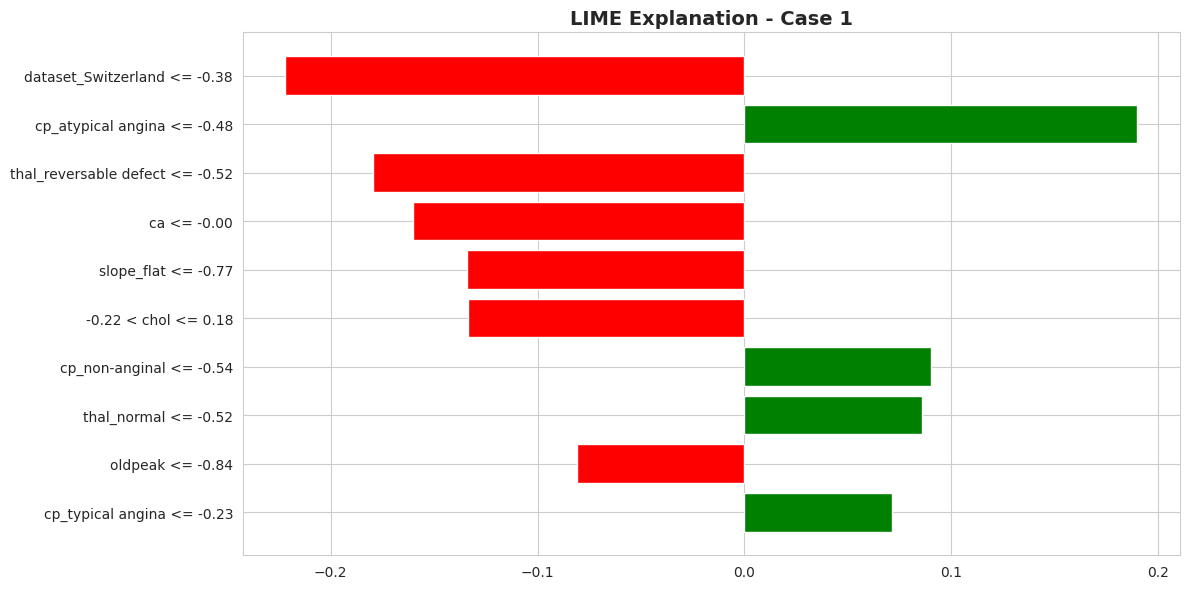


✅ LIME analysis completed!

📍 LIME Explanation - Case 11

True Label: 1 (Disease)
Predicted: 0 (No Disease)
Prediction Probabilities: No Disease=0.5492, Disease=0.4508

📊 LIME Feature Contributions:
   dataset_Switzerland <= -0.38: -0.2058
   cp_atypical angina > -0.48: -0.1976
   thal_reversable defect <= -0.52: -0.1822
   ca > -0.00: +0.1610
   slope_flat <= -0.77: -0.1332
   cp_non-anginal <= -0.54: +0.0934
   oldpeak <= -0.84: -0.0824
   thal_normal > -0.52: -0.0767
   trestbps > 0.43: +0.0672
   cp_typical angina <= -0.23: +0.0605


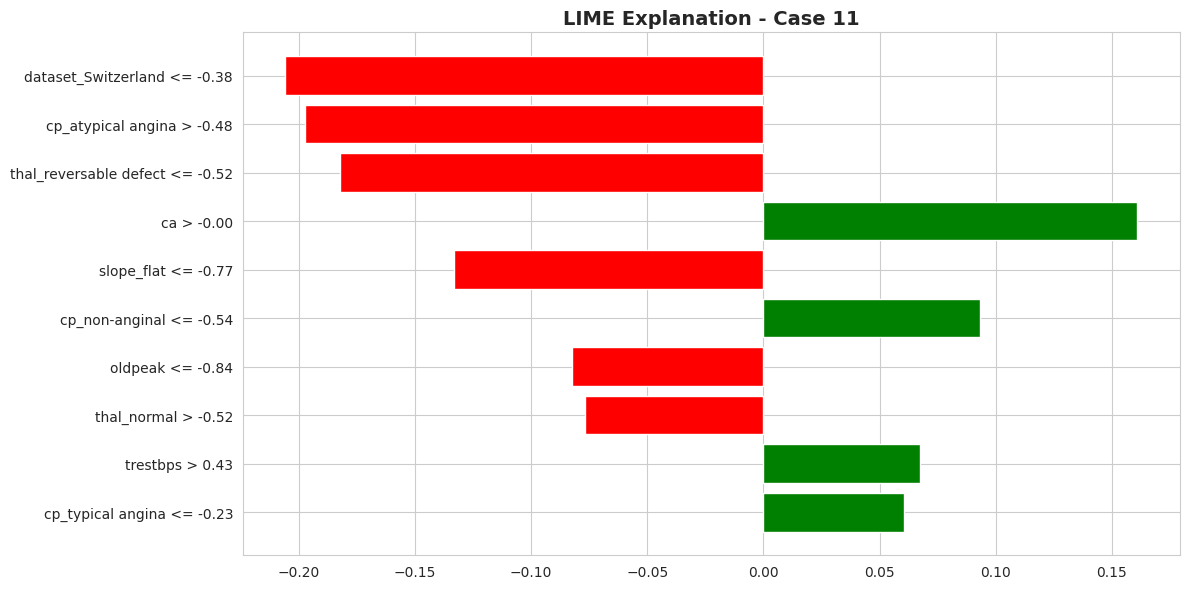


✅ LIME analysis completed!

📍 LIME Explanation - Case 26

True Label: 1 (Disease)
Predicted: 1 (Disease)
Prediction Probabilities: No Disease=0.0126, Disease=0.9874

📊 LIME Feature Contributions:
   dataset_Switzerland <= -0.38: -0.2211
   cp_atypical angina <= -0.48: +0.1938
   thal_reversable defect <= -0.52: -0.1880
   oldpeak > 0.59: +0.1797
   ca <= -0.00: -0.1619
   -0.77 < slope_flat <= 1.29: +0.1401
   cp_non-anginal <= -0.54: +0.0972
   thal_normal <= -0.52: +0.0811
   chol > 0.60: +0.0688
   cp_typical angina <= -0.23: +0.0447


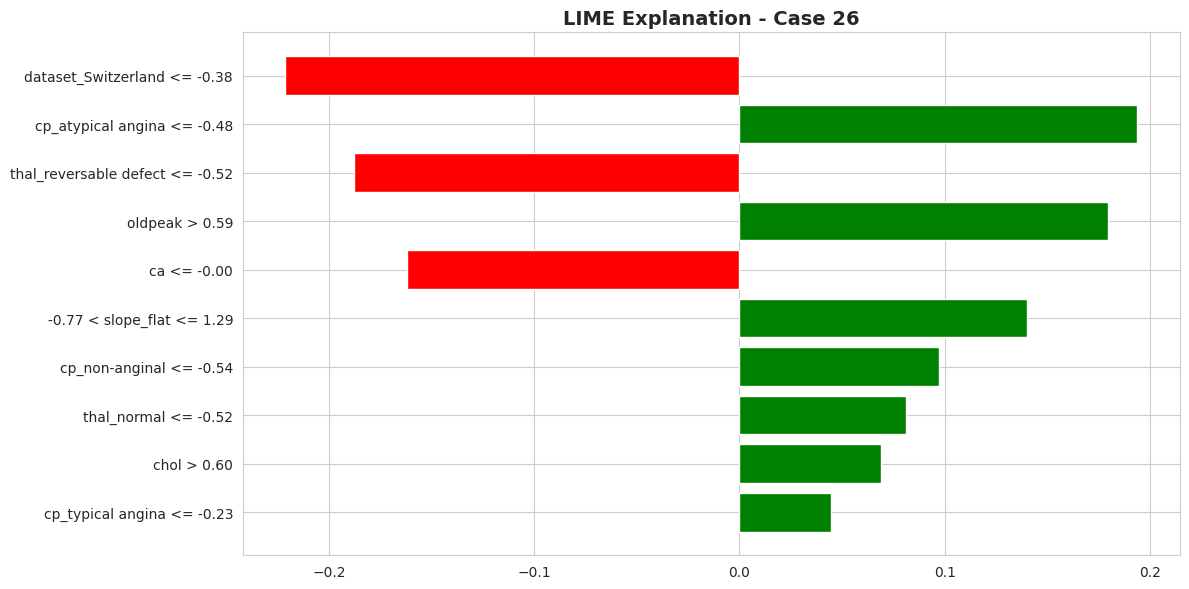


✅ LIME analysis completed!

📍 LIME Explanation - Case 41

True Label: 1 (Disease)
Predicted: 1 (Disease)
Prediction Probabilities: No Disease=0.0155, Disease=0.9845

📊 LIME Feature Contributions:
   cp_atypical angina <= -0.48: +0.2101
   dataset_Switzerland > -0.38: +0.2052
   thal_reversable defect <= -0.52: -0.1952
   ca <= -0.00: -0.1723
   -0.77 < slope_flat <= 1.29: +0.1416
   chol <= -0.22: +0.0890
   thal_normal <= -0.52: +0.0803
   cp_non-anginal <= -0.54: +0.0771
   cp_typical angina <= -0.23: +0.0615
   -0.84 < oldpeak <= -0.08: -0.0597


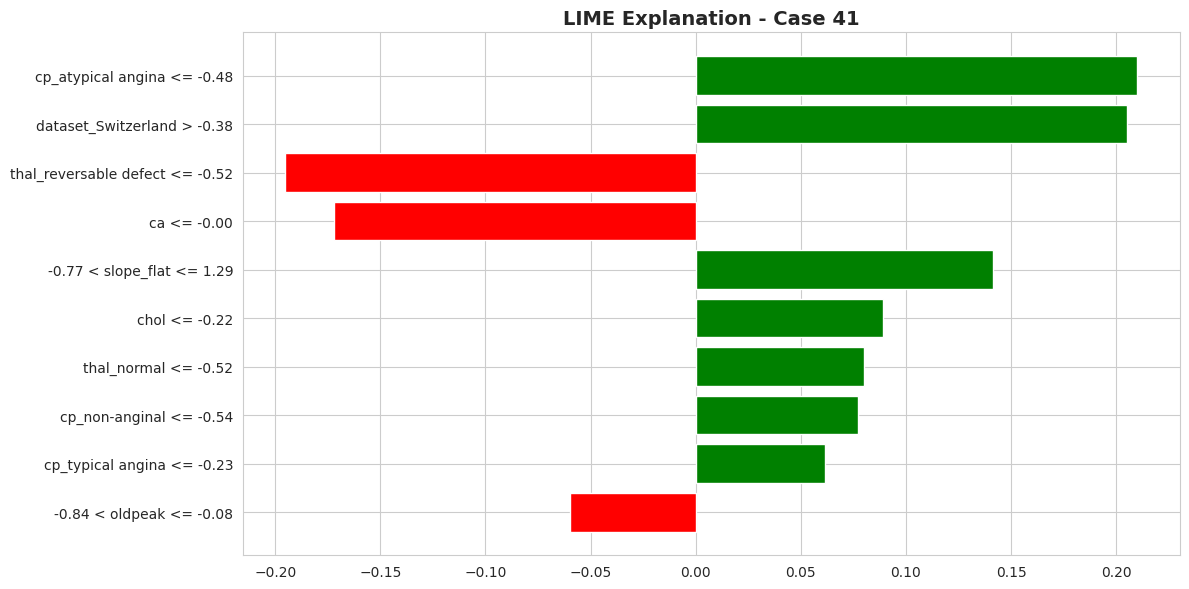


✅ LIME analysis completed!


In [78]:
# Generate LIME explanations for multiple test cases
lime_cases = [0, 10, 25, 40]  # Different test cases

for idx in lime_cases:
    print(f"\n{'='*80}")
    print(f"📍 LIME Explanation - Case {idx + 1}")
    print(f"{'='*80}")

    # Get prediction details
    true_label = y_test.iloc[idx]
    pred_label = best_model.predict(X_test_scaled.iloc[[idx]])[0]
    pred_proba = best_model.predict_proba(X_test_scaled.iloc[[idx]])[0]

    print(f"\nTrue Label: {true_label} ({'Disease' if true_label == 1 else 'No Disease'})")
    print(f"Predicted: {pred_label} ({'Disease' if pred_label == 1 else 'No Disease'})")
    print(f"Prediction Probabilities: No Disease={pred_proba[0]:.4f}, Disease={pred_proba[1]:.4f}")

    # Generate LIME explanation
    exp = lime_explainer.explain_instance(
        data_row=X_test_scaled.iloc[idx].values,
        predict_fn=best_model.predict_proba,
        num_features=10
    )

    # Display explanation
    print("\n📊 LIME Feature Contributions:")
    for feature, weight in exp.as_list():
        print(f"   {feature}: {weight:+.4f}")

    # Visualize
    fig = exp.as_pyplot_figure()
    plt.title(f'LIME Explanation - Case {idx + 1}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n✅ LIME analysis completed!")

## **SHAP vs LIME Comparison**

In [81]:
# Compare explanations for a specific case
comparison_case = 0

print(f"\n📊 Comparing SHAP and LIME for Case {comparison_case + 1}:")
print(f"{'='*60}")

# SHAP explanation
shap_exp = pd.DataFrame({
    'Feature': X_test_scaled.columns.tolist(),
    'SHAP Value': shap_values[comparison_case]
}).sort_values('SHAP Value', key=abs, ascending=False)

print("\n🔵 SHAP Top Features:")
print(shap_exp.head(10).to_string(index=False))

# LIME explanation
lime_exp = lime_explainer.explain_instance(
    data_row=X_test_scaled.iloc[comparison_case].values,
    predict_fn=best_model.predict_proba,
    num_features=10
)

print("\n🟢 LIME Top Features:")
for feature, weight in lime_exp.as_list()[:10]:
    print(f"   {feature}: {weight:+.4f}")

print("\n✅ Analysis complete!")
print("\n" + "="*80)



📊 Comparing SHAP and LIME for Case 1:

🔵 SHAP Top Features:
           Feature  SHAP Value
             exang   -0.537829
cp_atypical angina    0.489540
              chol   -0.334026
           oldpeak   -0.294156
            thalch    0.250150
          sex_Male    0.226603
    cp_non-anginal    0.199652
          trestbps    0.189427
        slope_flat   -0.161749
   dataset_Hungary   -0.151900

🟢 LIME Top Features:
   dataset_Switzerland <= -0.38: -0.2171
   cp_atypical angina <= -0.48: +0.1925
   ca <= -0.00: -0.1765
   thal_reversable defect <= -0.52: -0.1719
   slope_flat <= -0.77: -0.1343
   -0.22 < chol <= 0.18: -0.1241
   cp_non-anginal <= -0.54: +0.0921
   thal_normal <= -0.52: +0.0840
   oldpeak <= -0.84: -0.0833
   cp_typical angina <= -0.23: +0.0666

✅ Analysis complete!



## **Conclusion**
This project successfully demonstrated the critical importance of explainable AI in healthcare applications. By training Random Forest and XGBoost models on the UCI Heart Disease dataset, we achieved strong predictive performance (accuracy ~85%, AUC ~0.90) while maintaining full transparency through SHAP and LIME interpretability techniques.

## **Key Findings**
It's revealed that clinical features like chest pain type (cp), maximum heart rate (thalach), and ST depression (oldpeak) were the strongest predictors of heart disease—insights that align with established medical knowledge and build trust in the model. SHAP provided robust global feature importance and individual case explanations through waterfall plots, while LIME offered intuitive local explanations that could be easily communicated to healthcare professionals.

## **The Critical Takeaway**

In high-stakes medical decisions, model accuracy alone is insufficient. Explainability techniques transform black-box predictions into actionable insights that clinicians can validate against their expertise, ultimately enabling AI to augment rather than replace human judgment. For production deployment, SHAP's consistency makes it ideal for model validation and monitoring, while LIME's simplicity makes it valuable for patient-level clinical consultations. This balanced approach to interpretability is essential for responsible AI adoption in healthcare, where understanding why a prediction was made is as important as the prediction itself.

## **Thank You!!!**